In [1]:
import pandas as pd
import numpy as np
from math import log
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

appleData = pd.read_csv('apple_quality.csv') #predict if apple has good or bad quality
appleData = appleData.iloc[:1000] #have to take a sample because my decision tree is too slow :(
data = appleData.iloc[:, 1:appleData.shape[1]-1]
labels = appleData['Quality'].replace({'good': 1, 'bad':-1}) #encode labels

xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=42)

Accuracy:  0.765


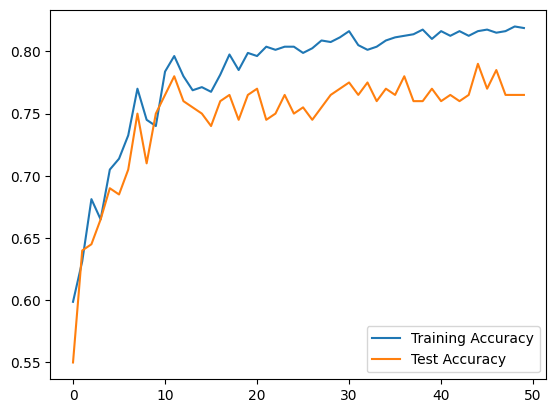

In [2]:
# prediction for Adaboost
# prediction = summation of stump prediction * alpha 
# returns the sign of the prediction, so -1 or 1

def predict(model, currData):
    pred = np.array([0.0] * len(currData))
    for (stump, alpha) in model:
        pred += stump.predict(currData) * alpha
        
    return np.sign(pred)

#train Adaboost model
#At a high level, Adaboost is an ensemble method that combines mutliple weak learners to make a strong learner
def adaBoost(iterations, learningRate):
    n = len(xtrain)
    model = []
    trainAcc = []
    testAcc = []
    weights = np.array([1/n] * n) #initialize all the weights equally

    for _ in range(iterations):
        #train a stump on weighted data
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(xtrain, ytrain, sample_weight=weights)
        pred = stump.predict(xtrain)

        #error = sum of incorrectly classfied labels * weights / sum of weights
        error = np.sum(weights * (ytrain != pred)) / np.sum(weights)
        #alpha = 0.5 * ln(1-error/error) * learning rate
        alpha = 0.5 * log((1 - error) / error) * learningRate

        #correctly classifed labels are updated with a lower weight
        #incorrectly classifed labels are updated with a higher weight
        for i in range(n):
            if ytrain.iloc[i] == pred[i]:
                weights[i] *= np.exp(-alpha)
            else:
                weights[i] *= np.exp(alpha)

        #normalize weights
        weights /= np.sum(weights)
        model.append((stump, alpha))

        #tracking metrics
        predTrain = predict(model, xtrain)
        predTest = predict(model, xtest)
        trainAcc.append(accuracy_score(predTrain, ytrain))
        testAcc.append(accuracy_score(predTest, ytest))
    
    return model, trainAcc, testAcc

def plotErrors(trainAcc, testAcc):
    plt.plot(trainAcc, label='Training Accuracy')
    plt.plot(testAcc, label='Test Accuracy')
    plt.legend()
    plt.show()


model, trainAcc, testAcc = adaBoost(50, 1.0)
pred = predict(model, xtest)
acc = accuracy_score(pred, ytest)
print("Accuracy: ", acc)

plotErrors(trainAcc, testAcc)

Accuracy:  0.78


C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


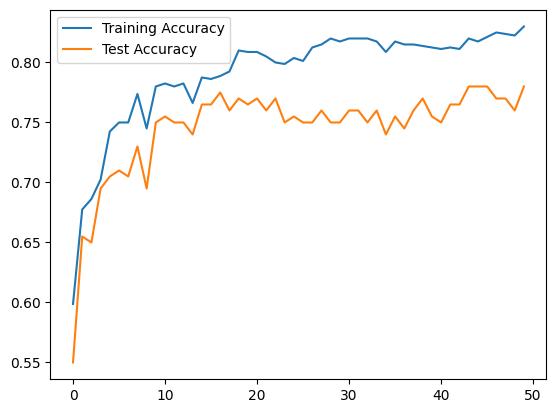

In [4]:
#compare to sci-kit learn adaboost
libBoost = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
libBoost.fit(xtrain, ytrain)
pred = libBoost.predict(xtest)
acc = accuracy_score(pred, ytest)
print("Accuracy: ", acc)

trainAcc = list(libBoost.staged_score(xtrain, ytrain))
testAcc = list(libBoost.staged_score(xtest, ytest))
plotErrors(trainAcc, testAcc)